# BITS ID : 2025AA05397
# Name : PRATYANSHU SHARMA
# Email : 2025aa05397@wilp.bits-pilani.ac.in
# Date : 03-02-2026


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout, LayerNormalization, GlobalAveragePooling1D, MultiHeadAttention


In [2]:
#Loading dataset

!pip install yfinance
import yfinance as yf

data = yf.download("AAPL", start="2018-01-01", end="2024-12-31")
series = data[['Close']]

print("Total time steps:", len(series))
series.head()


[*********************100%***********************]  1 of 1 completed

Total time steps: 1760


Price,Close
Ticker,AAPL
Date,
2018-01-02,40.341881
2018-01-03,40.334854
2018-01-04,40.522221
2018-01-05,40.983570
2018-01-08,40.831356


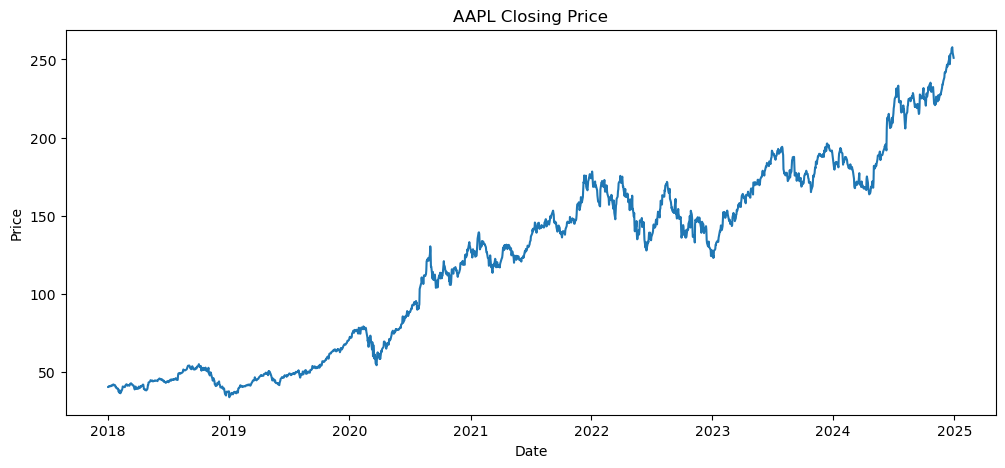

In [3]:
#Visualizing the closing price

plt.figure(figsize=(12,5))
plt.plot(series)
plt.title("AAPL Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [4]:
values = series.values

split = int(len(values) * 0.9)  # 90/10 split

train_data = values[:split]
test_data  = values[split:]

print("Train size:", train_data.shape)
print("Test size:", test_data.shape)


Train size: (1584, 1)
Test size: (176, 1)


In [5]:
scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_data)
test_scaled  = scaler.transform(test_data)

print("Scaled range:", train_scaled.min(), "to", train_scaled.max())


Scaled range: 0.0 to 1.0


In [6]:
SEQ_LEN = 30
HORIZON = 1

def create_sequences(data, seq_length, horizon):
    X, y = [], []
    
    for i in range(len(data) - seq_length - horizon + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i + seq_length])  # <-- single value, not slice
        
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, SEQ_LEN, HORIZON)
X_test, y_test   = create_sequences(test_scaled, SEQ_LEN, HORIZON)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)



X_train shape: (1554, 30, 1)
y_train shape: (1554, 1)


In [7]:
# ============================================================
# PART 1: LSTM MODEL FOR TIME SERIES PREDICTION
# Requirement: At least 2 stacked LSTM layers
# ============================================================

# Import required layer (if not already imported above)
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

# ------------------------------------------------------------
# Build Stacked LSTM Model
# ------------------------------------------------------------
# Layer 1: Returns full sequence so next LSTM can process it
# Layer 2: Learns higher-level temporal features
# Dense Layer: Outputs next time-step prediction

lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, 1)),  # First LSTM layer
    LSTM(32),                                                   # Second LSTM layer
    Dense(1)                                                    # Output layer
])

# ------------------------------------------------------------
# Compile Model
# ------------------------------------------------------------
# Optimizer: Adam (adaptive learning)
# Loss: Mean Squared Error (standard for regression)

lstm_model.compile(optimizer='adam', loss='mse')

# Display model architecture summary
lstm_model.summary()


d:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# ============================================================
# TRAINING THE LSTM MODEL
# ============================================================

history_lstm = lstm_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# ------------------------------------------------------------
# Record Initial and Final Training Loss (REQUIRED FOR GRADING)
# ------------------------------------------------------------
initial_lstm_loss = float(history_lstm.history['loss'][0])
final_lstm_loss   = float(history_lstm.history['loss'][-1])

print("Initial LSTM Loss:", initial_lstm_loss)
print("Final LSTM Loss:", final_lstm_loss)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0314 - val_loss: 0.0203
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0012 - val_loss: 0.0093
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0095
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0010 - val_loss: 0.0060
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 9.8835e-04 - val_loss: 0.0080
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.6110e-04 - val_loss: 0.0058
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.7828e-04 - val_loss: 0.0050
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 9.0109e-04 - val_loss: 0.0063
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 7.4825e-04 - val_loss: 0.0049
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.5173e-04 - val_loss: 0.0030
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 7.2823e-04 - val_loss: 0.0014
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━━

In [9]:
# ============================================================
# LSTM MODEL EVALUATION
# ============================================================

# Predict on test data
lstm_pred_scaled = lstm_model.predict(X_test)

# Inverse transform to original scale
y_test_actual = scaler.inverse_transform(y_test)
lstm_pred_actual = scaler.inverse_transform(lstm_pred_scaled)

# ------------------------------------------------------------
# Calculate Evaluation Metrics
# ------------------------------------------------------------

mae_lstm = mean_absolute_error(y_test_actual, lstm_pred_actual)
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, lstm_pred_actual))
mape_lstm = np.mean(np.abs((y_test_actual - lstm_pred_actual) / y_test_actual)) * 100
r2_lstm = r2_score(y_test_actual, lstm_pred_actual)

print("LSTM MAE :", mae_lstm)
print("LSTM RMSE:", rmse_lstm)
print("LSTM MAPE:", mape_lstm)
print("LSTM R2  :", r2_lstm)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
LSTM MAE : 4.001673868257704
LSTM RMSE: 4.885540934631516
LSTM MAPE: 1.7816129568041357
LSTM R2  : 0.8548378319320195


In [10]:
# ============================================================
# POSITIONAL ENCODING FOR TRANSFORMER
# ============================================================

import numpy as np
import tensorflow as tf

def positional_encoding(seq_len, d_model):
    positions = np.arange(seq_len)[:, np.newaxis]
    dims = np.arange(d_model)[np.newaxis, :]
    
    angle_rates = 1 / np.power(10000, (2 * (dims // 2)) / np.float32(d_model))
    angle_rads = positions * angle_rates
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    return tf.cast(angle_rads[np.newaxis, ...], dtype=tf.float32)


In [11]:
# ============================================================
# TRANSFORMER ENCODER BLOCK
# ============================================================

from tensorflow.keras.layers import LayerNormalization, Dropout, Dense, MultiHeadAttention

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    
    # ------------------------------------------------------------
    # Multi-Head Self-Attention
    # ------------------------------------------------------------
    attention_output = MultiHeadAttention(
        num_heads=num_heads, 
        key_dim=head_size
    )(inputs, inputs)
    
    attention_output = Dropout(dropout)(attention_output)
    attention_out = LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    # ------------------------------------------------------------
    # Feed Forward Network
    # ------------------------------------------------------------
    ffn = Dense(ff_dim, activation="relu")(attention_out)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn = Dropout(dropout)(ffn)
    
    return LayerNormalization(epsilon=1e-6)(attention_out + ffn)


In [12]:
# ============================================================
# PART 2: TRANSFORMER MODEL FOR TIME SERIES PREDICTION
# ============================================================

from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model

# Model dimension
d_model = 32

# ------------------------------------------------------------
# Input Layer
# ------------------------------------------------------------
inputs = Input(shape=(SEQ_LEN, 1))

# Project input to higher dimension
x = Dense(d_model)(inputs)

# ------------------------------------------------------------
# Add Positional Encoding (REQUIRED)
# ------------------------------------------------------------
x = x + positional_encoding(SEQ_LEN, d_model)

# ------------------------------------------------------------
# Transformer Encoder Block with Multi-Head Attention
# ------------------------------------------------------------
x = transformer_encoder(x, head_size=32, num_heads=4, ff_dim=64)

# Pool sequence output to single vector
x = GlobalAveragePooling1D()(x)

# Output layer for prediction
outputs = Dense(1)(x)

# Build and compile model
transformer_model = Model(inputs, outputs)
transformer_model.compile(optimizer='adam', loss='mse')

# Show architecture
transformer_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30, 32)    │         64 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 32)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 32)    │     16,800 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 32)    │          0 │ add[0][0],        │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 32)    │         64 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 30, 64)    │      2,112 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 30, 32)    │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 32)    │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 30, 32)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 32)    │         64 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         33 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,217 (82.88 KB)

 Trainable params: 21,217 (82.88 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# ============================================================
# TRAINING THE TRANSFORMER MODEL
# ============================================================

history_trans = transformer_model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Record loss values
initial_trans_loss = float(history_trans.history['loss'][0])
final_trans_loss   = float(history_trans.history['loss'][-1])

print("Initial Transformer Loss:", initial_trans_loss)
print("Final Transformer Loss:", final_trans_loss)


Epoch 1/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0959 - val_loss: 0.0051
Epoch 2/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0041 - val_loss: 0.0058
Epoch 3/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - val_loss: 0.0072
Epoch 4/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0038 - val_loss: 0.0144
Epoch 5/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - val_loss: 0.0102
Epoch 6/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0038 - val_loss: 0.0150
Epoch 7/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 8/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0033 - val_loss: 0.0024
Epoch 9/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028 - val_loss: 0.0019
Epoch 10/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0022 - val_loss: 0.0015
Epoch 11/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0021 - val_loss: 0.0050
Epoch 12/20
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_l

In [14]:
# ============================================================
# TRANSFORMER MODEL EVALUATION
# ============================================================

# Predict on test data
trans_pred_scaled = transformer_model.predict(X_test)

# Inverse transform to original scale
trans_pred_actual = scaler.inverse_transform(trans_pred_scaled)

# ------------------------------------------------------------
# Calculate Evaluation Metrics
# ------------------------------------------------------------

mae_trans = mean_absolute_error(y_test_actual, trans_pred_actual)
rmse_trans = np.sqrt(mean_squared_error(y_test_actual, trans_pred_actual))
mape_trans = np.mean(np.abs((y_test_actual - trans_pred_actual) / y_test_actual)) * 100
r2_trans = r2_score(y_test_actual, trans_pred_actual)

print("Transformer MAE :", mae_trans)
print("Transformer RMSE:", rmse_trans)
print("Transformer MAPE:", mape_trans)
print("Transformer R2  :", r2_trans)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Transformer MAE : 2.85530654698202
Transformer RMSE: 3.670044025048934
Transformer MAPE: 1.2858187900523268
Transformer R2  : 0.9180836333860234


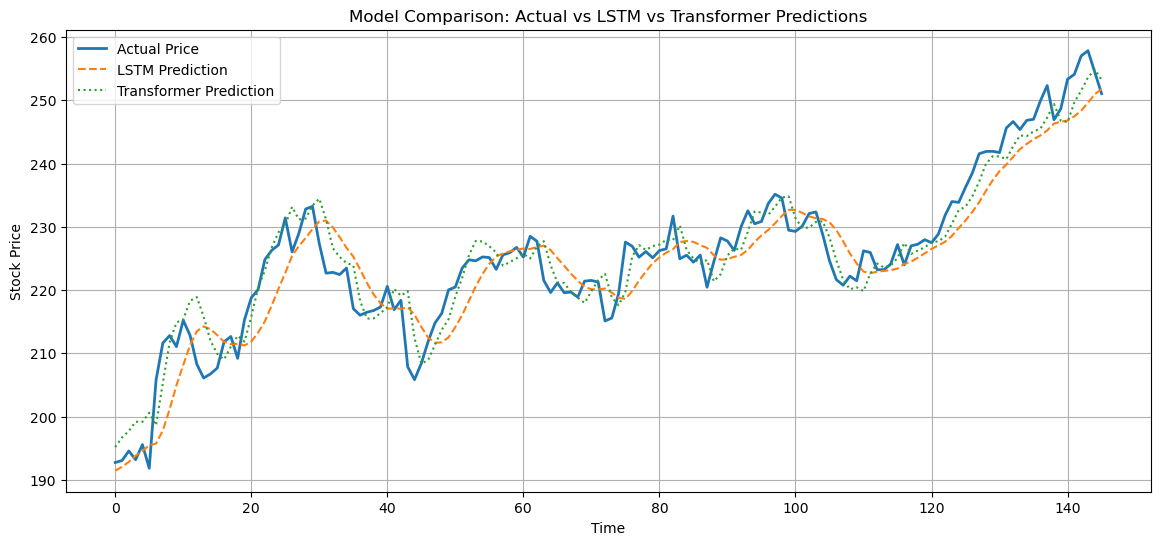

In [15]:
# ============================================================
# COMPARISON PLOT: ACTUAL vs LSTM vs TRANSFORMER
# ============================================================

plt.figure(figsize=(14,6))

plt.plot(y_test_actual, label="Actual Price", linewidth=2)
plt.plot(lstm_pred_actual, label="LSTM Prediction", linestyle="--")
plt.plot(trans_pred_actual, label="Transformer Prediction", linestyle=":")

plt.title("Model Comparison: Actual vs LSTM vs Transformer Predictions")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.grid(True)
plt.show()


In [16]:
# ============================================================
# ASSIGNMENT RESULTS JSON (DO NOT MODIFY FIELD NAMES)
# ============================================================

results = {
    "dataset_name": "AAPL Stock Closing Price",
    "sequence_length": SEQ_LEN,
    "train_test_ratio": "90/10",
    "prediction_horizon": HORIZON,
    
    "rnn_model": {
        "model_type": "LSTM",
        "framework": "keras",
        "architecture": {
            "n_layers": 2
        },
        "initial_loss": initial_lstm_loss,
        "final_loss": final_lstm_loss,
        "mae": mae_lstm,
        "rmse": rmse_lstm,
        "mape": mape_lstm,
        "r2_score": r2_lstm
    },
    
    "transformer_model": {
        "framework": "keras",
        "architecture": {
            "has_positional_encoding": True,
            "has_attention": True,
            "n_heads": 4
        },
        "initial_loss": initial_trans_loss,
        "final_loss": final_trans_loss,
        "mae": mae_trans,
        "rmse": rmse_trans,
        "mape": mape_trans,
        "r2_score": r2_trans
    }
}

import json
print(json.dumps(results, indent=4))


{
    "dataset_name": "AAPL Stock Closing Price",
    "sequence_length": 30,
    "train_test_ratio": "90/10",
    "prediction_horizon": 1,
    "rnn_model": {
        "model_type": "LSTM",
        "framework": "keras",
        "architecture": {
            "n_layers": 2
        },
        "initial_loss": 0.031419239938259125,
        "final_loss": 0.0005265986546874046,
        "mae": 4.001673868257704,
        "rmse": 4.885540934631516,
        "mape": 1.7816129568041357,
        "r2_score": 0.8548378319320195
    },
    "transformer_model": {
        "framework": "keras",
        "architecture": {
            "has_positional_encoding": true,
            "has_attention": true,
            "n_heads": 4
        },
        "initial_loss": 0.09591002017259598,
        "final_loss": 0.0012962155742570758,
        "mae": 2.85530654698202,
        "rmse": 3.670044025048934,
        "mape": 1.2858187900523268,
        "r2_score": 0.9180836333860234
    }
}
